# HirePredict-AI : Prédiction du succès d'un entretien d'embauche
Ce notebook présente une démarche complète d'Intelligence Artificielle pour prédire si un candidat sera retenu à partir de données de CV (âge, diplôme, test d'anglais, expérience, etc.). Projet de Data Science avec optimisation Optuna et API FastAPI professionnelle.

## 1. Importation des bibliothèques nécessaires

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Chargement et exploration des données

In [ ]:
data = pd.read_csv('../data/candidats.csv')
data.head()

,age,diplome,note_anglais,experience,entreprises_precedentes,distance_km,score_entretien,score_competence,score_personnalite,sexe,retenu
0,28,BTS,63,0,0,25.2,5.7,3.3,60,F,0
1,37,Master,74,10,1,3.3,6.6,7.7,76,F,1
2,41,Master,100,10,2,0.7,7.7,7.4,92,F,1
3,28,Licence,86,15,1,6.6,9.9,9.7,86,M,1
4,42,Master,64,15,2,0.1,8.5,6.2,85,M,1


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      10000 non-null  int64  
 1   diplome                  10000 non-null  object 
 2   note_anglais             10000 non-null  int64  
 3   experience               10000 non-null  int64  
 4   entreprises_precedentes  10000 non-null  int64  
 5   distance_km              10000 non-null  float64
 6   score_entretien          10000 non-null  float64
 7   score_competence         10000 non-null  float64
 8   score_personnalite       10000 non-null  int64  
 9   sexe                     10000 non-null  object 
 10  retenu                   10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [42]:
data.describe(include='all')

,age,diplome,note_anglais,experience,entreprises_precedentes,distance_km,score_entretien,score_competence,score_personnalite,sexe,retenu
count,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,Licence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
freq,NaN,3545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5014,NaN
mean,32.465300,NaN,67.334000,6.201600,1.716700,9.060070,6.940360,6.759250,74.159600,NaN,0.500000
std,6.958968,NaN,15.346498,4.112815,1.412601,6.452231,1.547428,1.670478,11.546006,NaN,0.500025
min,21.000000,NaN,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,45.000000,NaN,0.000000
25%,26.000000,NaN,58.000000,3.000000,1.000000,4.200000,5.700000,5.500000,66.000000,NaN,0.000000
50%,32.000000,NaN,69.000000,6.000000,1.000000,7.300000,7.100000,7.000000,75.000000,NaN,0.500000
75%,39.000000,NaN,77.000000,9.000000,3.000000,13.100000,8.200000,8.100000,83.000000,NaN,1.000000


> ## *Comparaison*
Le pilier « Comparaison » analyse la manière dont les différents groupes de l'ensemble de données se comparent entre eux sur divers critères. Il s'agit notamment de comparer les candidats embauchés et non embauchés sur des critères tels que l'âge, les résultats d'entretien, l'expérience, etc.

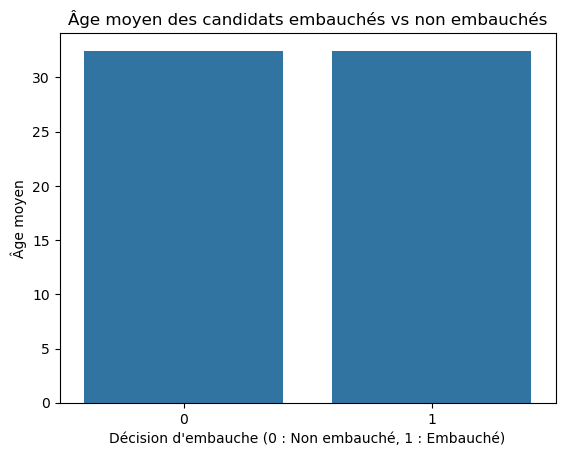

In [43]:
# 1. Quelle est l'âge moyen des candidats embauchés vers non embauchés ?

avg_age_hired = data.groupby('retenu')['age'].mean()

sns.barplot(x=avg_age_hired.index, y=avg_age_hired.values)

plt.title("Âge moyen des candidats embauchés vs non embauchés")
plt.ylabel("Âge moyen")
plt.xlabel("Décision d'embauche (0 : Non embauché, 1 : Embauché)")
plt.show()

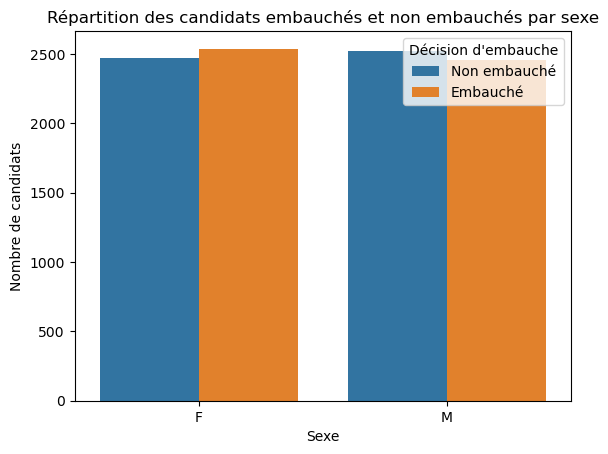

In [44]:
# 2. Quelle est la répartition des candidats embauchés et non embauchés par sexe ?
sns.countplot(x='sexe', hue='retenu', data=data)
plt.title("Répartition des candidats embauchés et non embauchés par sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre de candidats")
plt.legend(title='Décision d\'embauche', loc='upper right', labels=['Non embauché', 'Embauché'])
plt.show()

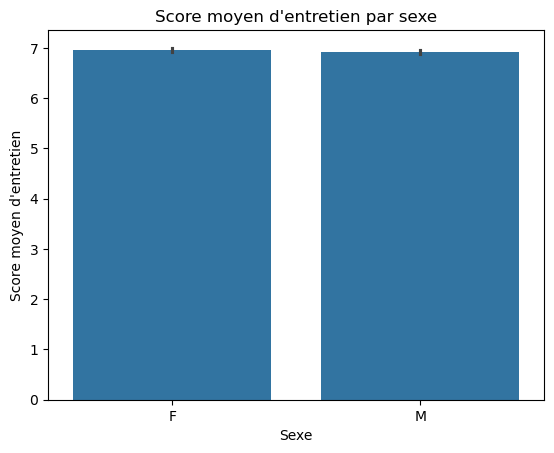

In [45]:
# 3. Comment le score moyen d'entretien varie-t-il entre les candidats masculins et féminins ?
sns.barplot(x='sexe', y='score_entretien', data=data)
plt.title("Score moyen d'entretien par sexe")
plt.xlabel("Sexe")
plt.ylabel("Score moyen d'entretien")
plt.show()


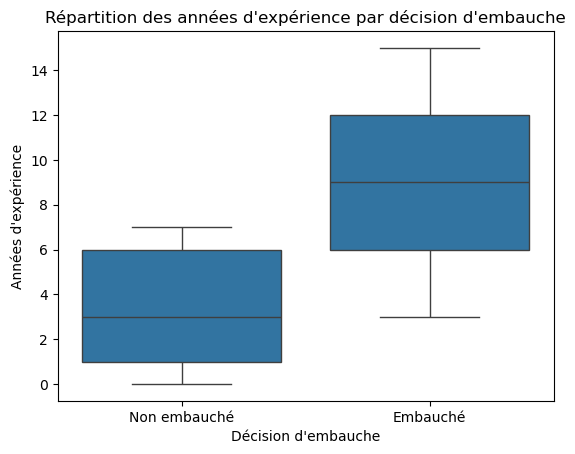

In [46]:
# 4. Quelle est la répartition des années d'expérience pour les candidats embauchés vs non embauchés ?
sns.boxplot(x='retenu', y='experience', data=data)
plt.title("Répartition des années d'expérience par décision d'embauche")
plt.xlabel("Décision d'embauche")
plt.ylabel("Années d'expérience")
plt.xticks(ticks=[0, 1], labels=['Non embauché', 'Embauché'])
plt.show()

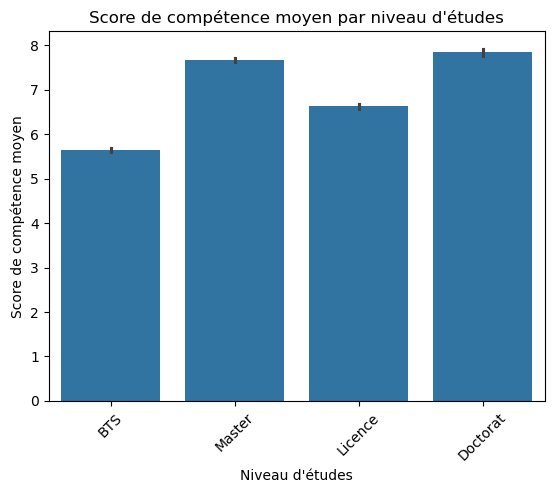

In [47]:
# 5. Comparer le score de compétence moyen selon les niveaux d'études

sns.barplot(x='diplome', y='score_competence', data=data)
plt.title("Score de compétence moyen par niveau d'études")
plt.xlabel("Niveau d'études")
plt.ylabel("Score de compétence moyen")
plt.xticks(rotation=45)
plt.show()

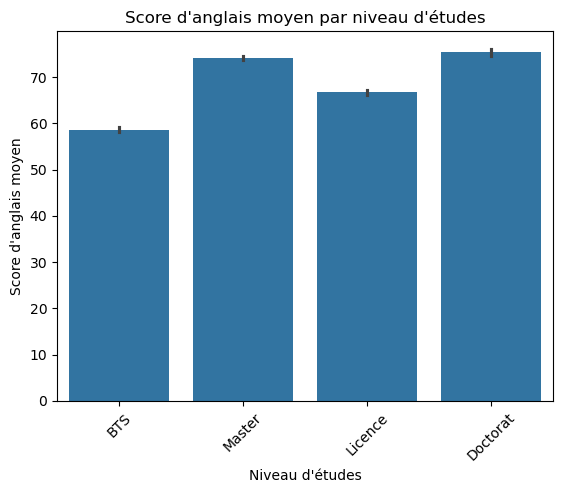

In [48]:
# 6. Comparer le score d'anglais moyen selon les niveaux d'études

sns.barplot(x='diplome', y='note_anglais', data=data)
plt.title("Score d'anglais moyen par niveau d'études")
plt.xlabel("Niveau d'études")
plt.ylabel("Score d'anglais moyen")
plt.xticks(rotation=45)
plt.show()


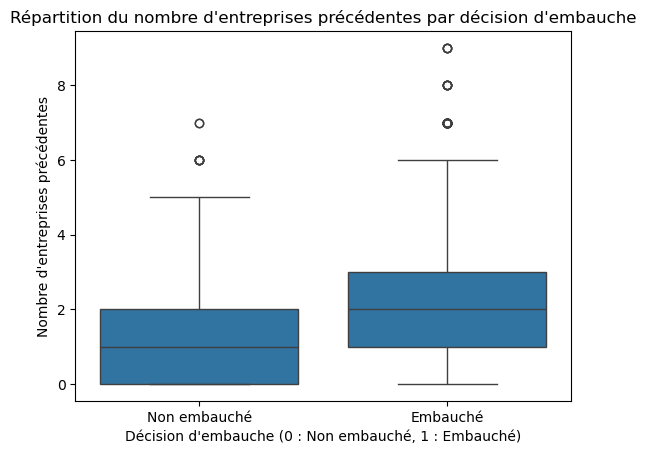

In [49]:
# 6. Comment le nombre d'entreprises précédentes varie-t-il entre les candidats embauchés et non embauchés ?

sns.boxplot(x='retenu', y='entreprises_precedentes', data=data)
plt.title("Répartition du nombre d'entreprises précédentes par décision d'embauche")
plt.xlabel("Décision d'embauche (0 : Non embauché, 1 : Embauché)")
plt.ylabel("Nombre d'entreprises précédentes")
plt.xticks(ticks=[0, 1], labels=['Non embauché', 'Embauché'])
plt.show()

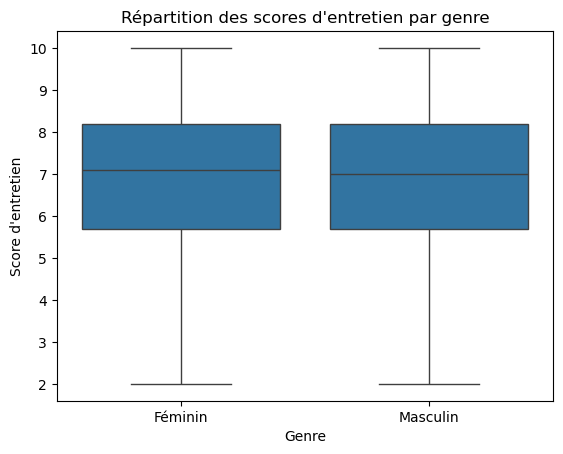

In [50]:
# 8. Quelle est la répartition des scores d'entretien pour les candidats masculins et féminins ?

sns.boxplot(x='sexe', y='score_entretien', data=data)
plt.title("Répartition des scores d'entretien par genre")
plt.xlabel("Genre")
plt.ylabel("Score d'entretien")
plt.xticks(ticks=[0, 1], labels=['Féminin', 'Masculin'])
plt.show()


> ## *Relations entre les variables*
Le pilier « Relations entre les variables » explore les relations entre les différentes variables du jeu de données. Il s'agit d'analyser comment les variables sont corrélées entre elles et comment elles influencent la décision d'embauche.

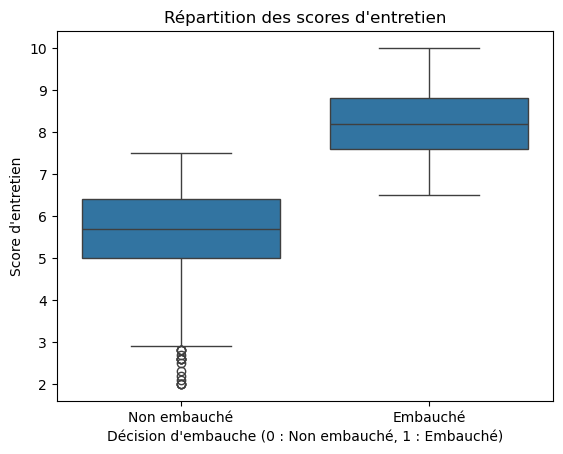

In [51]:
# 1. Existe-t-il une corrélation entre les scores d'entretien et les décisions d'embauche ?

sns.boxplot(x='retenu', y='score_entretien', data=data)
plt.title("Répartition des scores d'entretien")
plt.xlabel("Décision d'embauche (0 : Non embauché, 1 : Embauché)")
plt.ylabel("Score d'entretien")
plt.xticks(ticks=[0, 1], labels=['Non embauché', 'Embauché'])
plt.show()


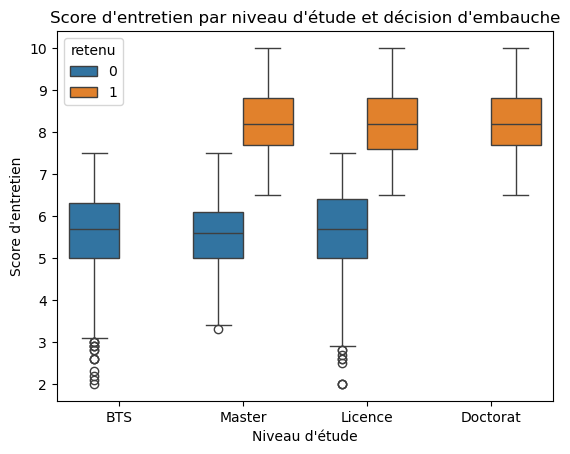

In [52]:
# 2. Comment le niveau d'etude influence-t-elle la corrélation entre le score d'entretien et la décision d'embauche ?

sns.boxplot(x='diplome', y='score_entretien', hue="retenu" ,data=data)
plt.title("Score d'entretien par niveau d'étude et décision d'embauche")
plt.xlabel("Niveau d'étude")
plt.ylabel("Score d'entretien")
plt.show()



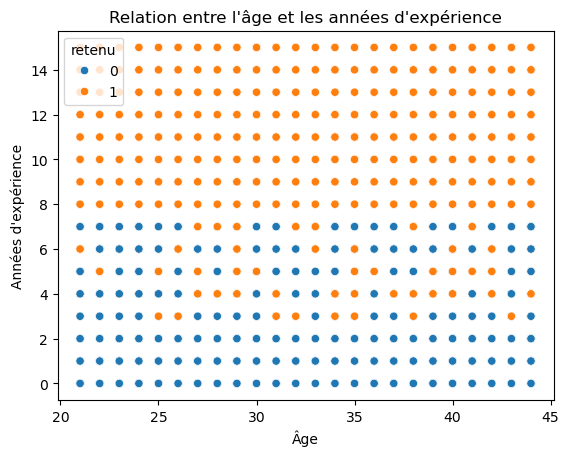

In [53]:
# 3. Quelle est la relation entre l'âge et le nombre d'années d'expérience ?

sns.scatterplot(x='age', y='experience', hue="retenu", data=data)
plt.title("Relation entre l'âge et les années d'expérience")
plt.xlabel("Âge")
plt.ylabel("Années d'expérience")
plt.show()


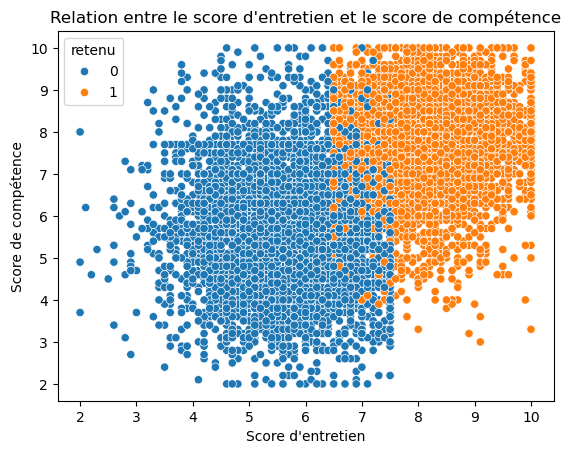

In [54]:
# 4. Comment les scores d'entretien corrèlent-ils avec les scores de compétence ?
sns.scatterplot(x='score_entretien', y='score_competence', hue="retenu", data=data)
plt.title("Relation entre le score d'entretien et le score de compétence")
plt.xlabel("Score d'entretien")
plt.ylabel("Score de compétence")
plt.show()


> ## *Distribution des variables*
Le pilier « Distribution des variables » examine la distribution des différentes variables du jeu de données. Il s'agit d'analyser comment les valeurs des variables sont réparties et si elles suivent une distribution particulière (normale, asymétrique, etc.).

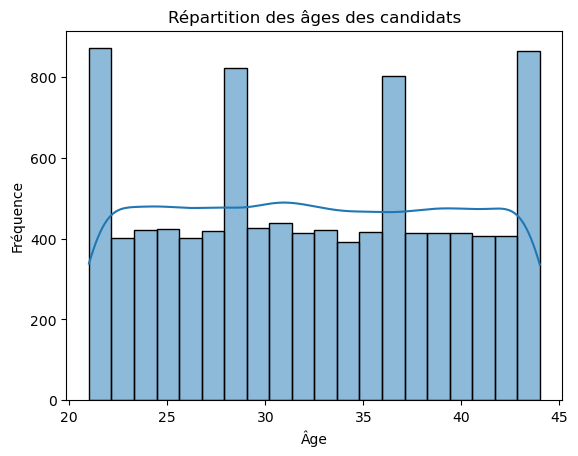

In [55]:
# 1. Quelle est la répartition des âges parmi tous les candidats ?

sns.histplot(data['age'], kde=True)
plt.title('Répartition des âges des candidats')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

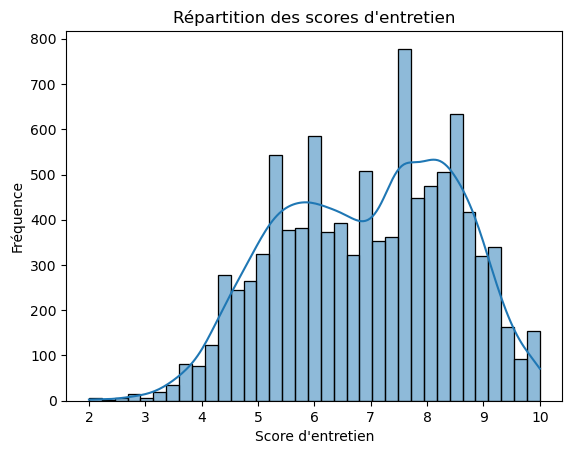

In [56]:
# 2. Comment les scores d'entretien sont-ils répartis dans l'ensemble des données ?

sns.histplot(data['score_entretien'], kde=True)
plt.title('Répartition des scores d\'entretien')
plt.xlabel('Score d\'entretien')
plt.ylabel('Fréquence')
plt.show()


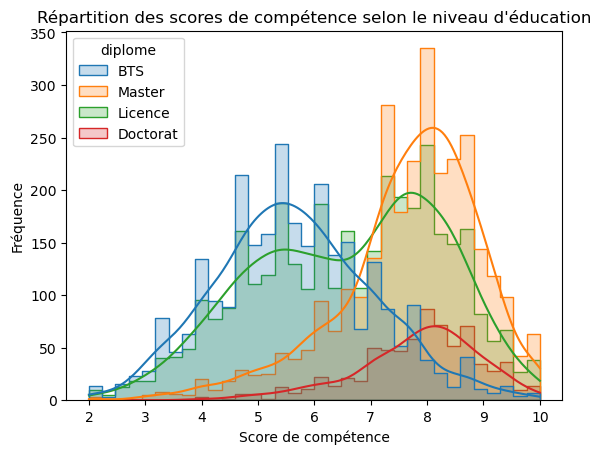

In [57]:
# 3. Quelle est la répartition des scores de compétence selon les niveaux d'éducation ?

sns.histplot(data, x='score_competence', hue='diplome', kde=True, element='step')
plt.title('Répartition des scores de compétence selon le niveau d\'éducation')
plt.xlabel('Score de compétence')
plt.ylabel('Fréquence')
plt.show()


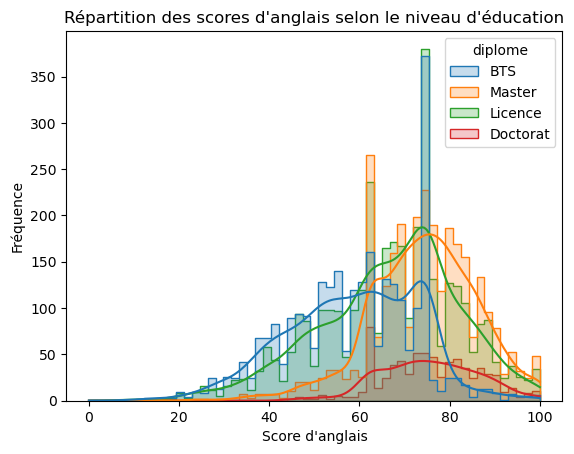

In [58]:
# 4. Repartition des scores d'anglais selon les niveaux d'éducation
sns.histplot(data, x='note_anglais', hue='diplome', kde=True, element='step')
plt.title('Répartition des scores d\'anglais selon le niveau d\'éducation')
plt.xlabel('Score d\'anglais')
plt.ylabel('Fréquence')
plt.show()

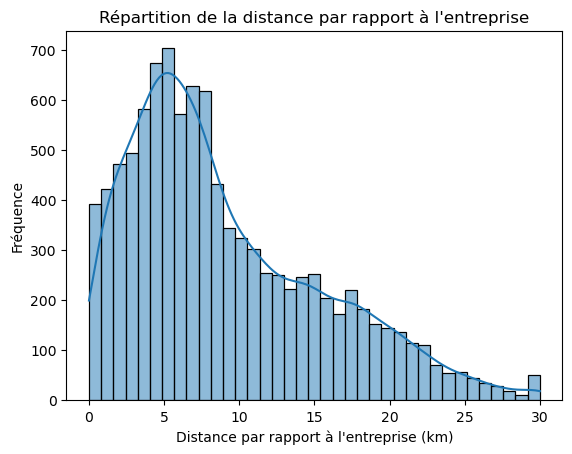

In [59]:
# 5. Comment la distance par rapport à l'entreprise est-elle répartie parmi les candidats ?
sns.histplot(data['distance_km'], kde=True)
plt.title('Répartition de la distance par rapport à l\'entreprise')
plt.xlabel('Distance par rapport à l\'entreprise (km)')
plt.ylabel('Fréquence')
plt.show()

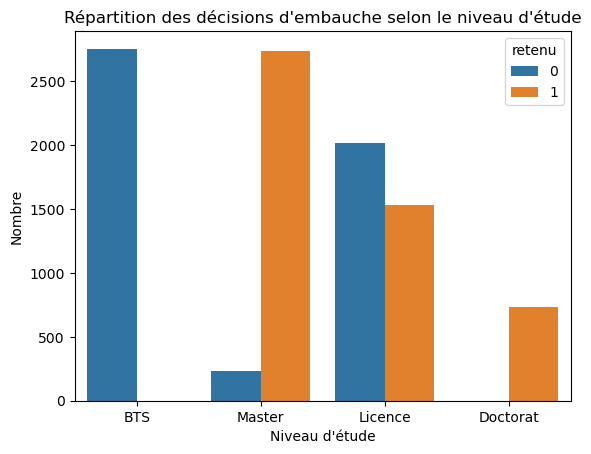

In [60]:
# 7. Quelle est la répartition des décisions d'embauche selon le niveau d'etude ?

sns.countplot(x='diplome', hue='retenu', data=data)
plt.title('Répartition des décisions d\'embauche selon le niveau d\'étude')
plt.xlabel('Niveau d\'étude')
plt.ylabel('Nombre')
plt.show()

> ## *Composition des variables*
Le pilier « Composition des variables » analyse la composition des différentes variables du jeu de données. Il s'agit de comprendre comment les variables sont constituées et quelles sont les différentes catégories ou valeurs possibles pour chaque variable. Cela peut inclure des variables catégorielles, numériques, ou des variables de type texte.

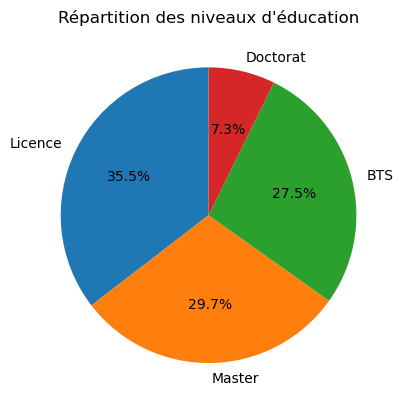

In [61]:
# 1. Quel pourcentage de candidats ont un diplôme de licence par rapport aux autres niveaux d'éducation ?

edu_level_counts = data['diplome'].value_counts(normalize=True) * 100
edu_level_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Répartition des niveaux d'éducation")
plt.ylabel('')
plt.show()

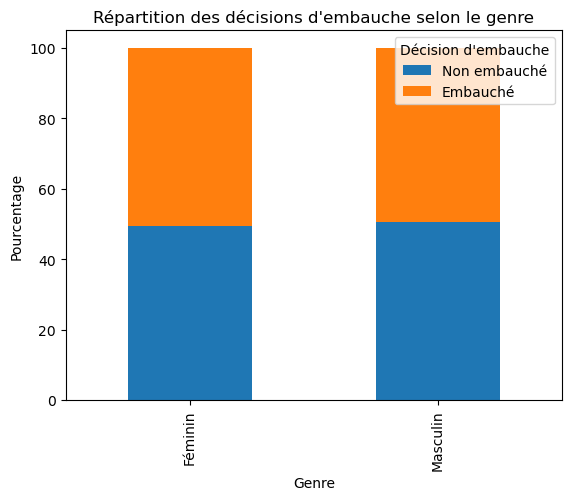

In [62]:
# 2. Comment la décision d'embauche se répartit-elle entre candidats masculins et féminins ?
gender_hiring_split = data.groupby('sexe')['retenu'].value_counts(normalize=True).unstack() * 100
gender_hiring_split.plot(kind='bar', stacked=True)
plt.title('Répartition des décisions d\'embauche selon le genre')
plt.ylabel('Pourcentage')
plt.xlabel('Genre')
plt.xticks(ticks=[0, 1], labels=['Féminin', 'Masculin'])
plt.legend(title='Décision d\'embauche', loc='upper right', labels=['Non embauché', 'Embauché'])
plt.show()

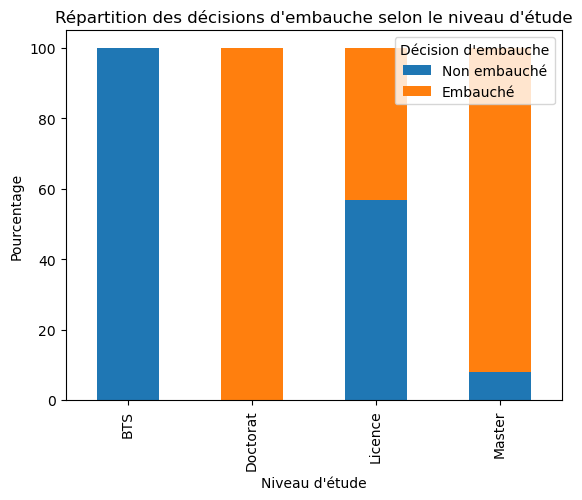

In [63]:
# 3. Quelle proportion de candidats a été embauchée selon le niveau d'etude ?

edu_hiring_split = data.groupby('diplome')['retenu'].value_counts(normalize=True).unstack() * 100
edu_hiring_split.plot(kind='bar', stacked=True)
plt.title('Répartition des décisions d\'embauche selon le niveau d\'étude')
plt.xlabel('Niveau d\'étude')
plt.ylabel('Pourcentage')
plt.legend(title='Décision d\'embauche', loc='upper right', labels=['Non embauché', 'Embauché'])
plt.show()


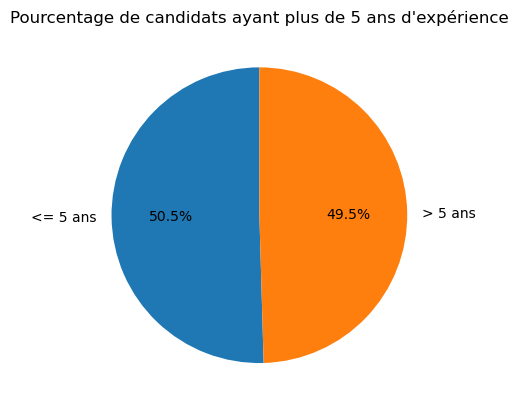

In [64]:
# 4. Quel pourcentage de candidats ont plus de 5 ans d'expérience ?

experience_counts = (data['experience'] > 5).value_counts(normalize=True) * 100
experience_counts.plot(kind='pie', labels=['<= 5 ans', '> 5 ans'], autopct='%1.1f%%', startangle=90)
plt.title('Pourcentage de candidats ayant plus de 5 ans d\'expérience')
plt.ylabel('')
plt.show()


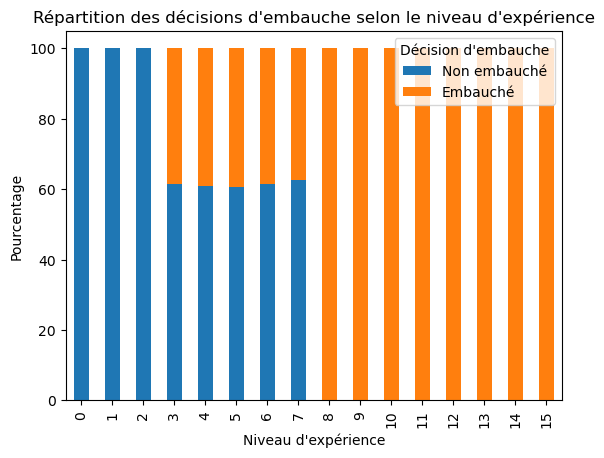

In [65]:
# 5. Quelle proportion de candidats a été embauchée en fonction de leurs niveaux d'expérience ?

experience_hiring_split = data.groupby('experience')['retenu'].value_counts(normalize=True).unstack() * 100
experience_hiring_split.plot(kind='bar', stacked=True)
plt.title('Répartition des décisions d\'embauche selon le niveau d\'expérience')
plt.xlabel('Niveau d\'expérience')
plt.ylabel('Pourcentage')
plt.legend(title='Décision d\'embauche', loc='upper right', labels=['Non embauché', 'Embauché'])
plt.show()


## 3. Prétraitement des données

In [ ]:
# Affichage des valeurs manquantes

data.isnull().sum()

age                        0
diplome                    0
note_anglais               0
experience                 0
entreprises_precedentes    0
distance_km                0
score_entretien            0
score_competence           0
score_personnalite         0
sexe                       0
retenu                     0
dtype: int64

In [ ]:
# Affichage des doublons

data.duplicated().sum()

np.int64(0)

In [79]:
X = data.drop('retenu', axis=1)
y = data['retenu']

In [77]:
# Détection des types de variables
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

print("Catégorielles :", cat_features)
print("Numériques :", num_features)

Catégorielles : ['diplome', 'sexe']
Numériques : ['age', 'note_anglais', 'experience', 'entreprises_precedentes', 'distance_km', 'score_entretien', 'score_competence', 'score_personnalite']


> ## *Pipeline de prétraitement*
Le pilier « Pipeline de prétraitement » décrit les étapes de préparation des données avant l'entraînement du modèle. Cela inclut le traitement des valeurs manquantes, la normalisation des données, la transformation des variables catégorielles en variables numériques, et la séparation des données en ensembles d'entraînement et de test.

In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

In [80]:
# Séparation des données en ensembles d'entraînement et de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

>## *Optimisation des hyperparamètres avec Optuna*
Le pilier « Optimisation des hyperparamètres » décrit les étapes d'optimisation des paramètres du modèle pour améliorer ses performances. Cela inclut la recherche des meilleurs paramètres pour le modèle, l'évaluation des performances du modèle sur les données de test, et la sélection du meilleur modèle en fonction de ses performances.

In [ ]:
def define_model(trial):

    """    Fonction pour définir le modèle en fonction des hyperparamètres suggérés par Optuna.
    Args:
        trial (optuna.Trial): Un objet Trial d'Optuna pour suggérer des hyperparamètres.
    Returns:
        tuple: Le nom du classificateur et l'instance du modèle.
    """
    
    classifier_name = trial.suggest_categorical('classifier', ['random_forest', 'logistic_regression', 'xgboost', 'svc'])
    
    if classifier_name == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
            'random_state': 42,
            'n_jobs': -1
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'logistic_regression':
        c_logreg = trial.suggest_float('C_logreg', 1e-4, 10.0, log=True)
        params = {
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'C': c_logreg,
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
            'max_iter': 1000,
            'random_state': 42
        }
        model = LogisticRegression(**params)


    elif classifier_name == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        model = XGBClassifier(**params)

    elif classifier_name == 'svc':
        c_svc = trial.suggest_float('C_svc', 0.1, 10.0)
        params = {
            'C': c_svc,
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'probability': True
        }
        model = SVC(**params)

    return classifier_name, model

In [82]:
def objective(trial):

    """    
    Fonction objectif pour Optuna.
    Args:
        trial (optuna.Trial): Un objet Trial d'Optuna pour suggérer des hyperparamètres.
    Returns:
        float: Le score de validation croisée du modèle.
    """
    
    classifier_name, model = define_model(trial)
    pipe = Pipeline([('preproc', preprocessor), ('clf', model)])
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score



In [83]:
# ========== 3. OPTIMISATION AVEC OPTUNA ==========
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=40)

print("\n✅ Meilleurs paramètres trouvés :")
print(study.best_params)

[I 2025-07-08 14:37:17,484] A new study created in memory with name: no-name-07ced91b-aa42-4438-9698-3fbd82209f64
[I 2025-07-08 14:37:17,791] Trial 0 finished with value: 0.9829296875000001 and parameters: {'classifier': 'logistic_regression', 'C_logreg': 0.0006026889128682511, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9829296875000001.
[I 2025-07-08 14:37:22,880] Trial 1 finished with value: 0.999958125 and parameters: {'classifier': 'xgboost', 'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.06318730785749581, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119}. Best is trial 1 with value: 0.999958125.
[I 2025-07-08 14:37:25,056] Trial 2 finished with value: 0.9999290625 and parameters: {'classifier': 'xgboost', 'n_estimators': 217, 'max_depth': 6, 'learning_rate': 0.1422602954229404, 'subsample': 0.8925879806965068, 'colsample_bytree': 0.5998368910791798}. Best is trial 1 with value: 0.999958125.
[I 2025-07-08 14:37:30,165] Tri


✅ Meilleurs paramètres trouvés :
{'classifier': 'random_forest', 'n_estimators': 254, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [110]:
# ========== 4. RÉCUPÉRATION DES MEILLEURS PARAMÈTRES ET ENTRAÎNEMENT DU MODÈLE ==========

best_params = study.best_params.copy()
algo = best_params.pop('classifier')

# Gestion des noms de paramètres spécifiques
if 'C_logreg' in best_params:
    best_params['C'] = best_params.pop('C_logreg')
if 'C_svc' in best_params:
    best_params['C'] = best_params.pop('C_svc')

# Instanciation du modèle optimisé
if algo == 'random_forest':
    model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
elif algo == 'logistic_regression':
    model = LogisticRegression(**best_params, max_iter=1000, random_state=42)
elif algo == 'xgboost':
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
elif algo == 'svc':
    model = SVC(**best_params, probability=True)

# Création du pipeline final avec prétraitement
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', model)
])

# Entraînement
pipe.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred = pipe.predict(X_test)

# Affichage de l'accuracy
print(f'\n🎯 Accuracy sur le test du meilleur modèle ({algo}) : {accuracy_score(y_test, y_pred):.4f}')



🎯 Accuracy sur le test du meilleur modèle (random_forest) : 0.9975


In [ ]:
print(pipe.named_steps['clf'])

RandomForestClassifier(max_depth=17, min_samples_split=5, n_estimators=254,
                       n_jobs=-1, random_state=42)


In [113]:
# ========== 5. COMPARAISON AVEC D'AUTRES MODÈLES CLASSIQUES ==========

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVC': SVC(probability=True),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
}

# Dictionnaire pour stocker les résultats
results = {}

# Boucle de comparaison
for name, model in models.items():
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    # Vérifie si le modèle supporte predict_proba pour calculer l'AUC
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba)
    else:
        auc = None
    
    results[name] = {
        'accuracy': acc,
        'auc': auc
    }


In [114]:
print(pipe.named_steps['clf'])

RandomForestClassifier(n_jobs=-1, random_state=42)


In [115]:
# ========== 6. Affichage des résultats comparés ==========

df_results = pd.DataFrame(results).T.sort_values(by='auc', ascending=False)

print("\n📊 Résultats des différents modèles :\n")
print(df_results.round(4)) 



📊 Résultats des différents modèles :

                    accuracy     auc
XGBoost               0.9950  0.9999
RandomForest          0.9970  0.9998
LogisticRegression    0.9955  0.9998
SVC                   0.9950  0.9997


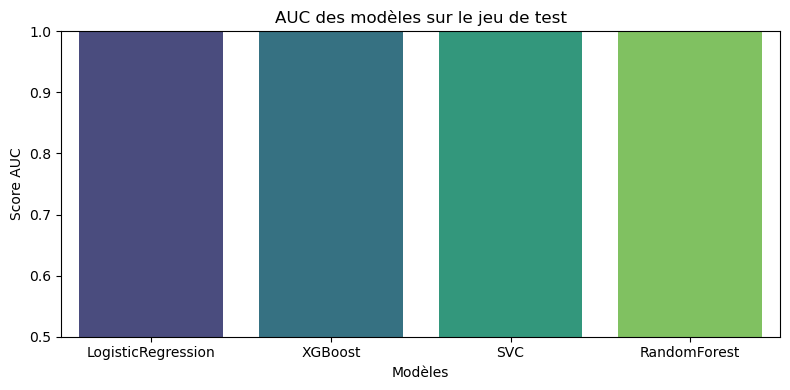

In [116]:
# ========== 7. Visualisation des scores AUC ==========

auc_scores = {
    model: metrics['auc']
    for model, metrics in results.items()
    if metrics['auc'] is not None
}

# Barplot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(auc_scores.keys()), y=list(auc_scores.values()), palette='viridis')
plt.title('AUC des modèles sur le jeu de test')
plt.ylabel('Score AUC')
plt.xlabel('Modèles')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


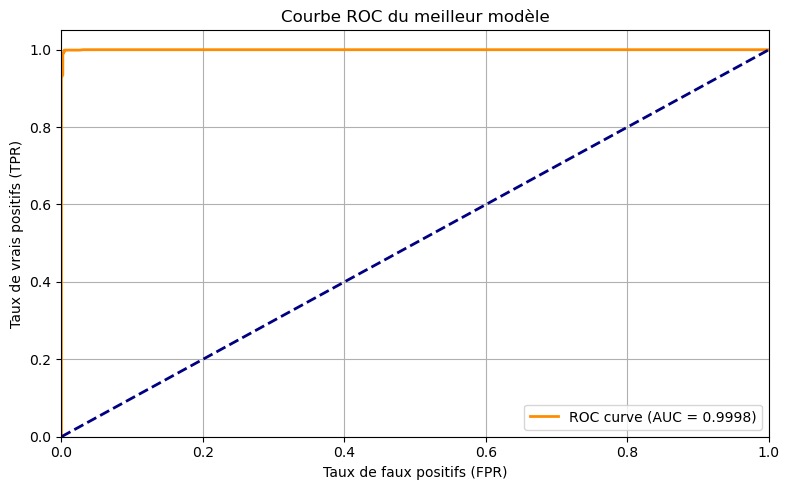

In [120]:
# Prédiction des probabilités avec le meilleur modèle

y_proba = pipe.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC du meilleur modèle')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


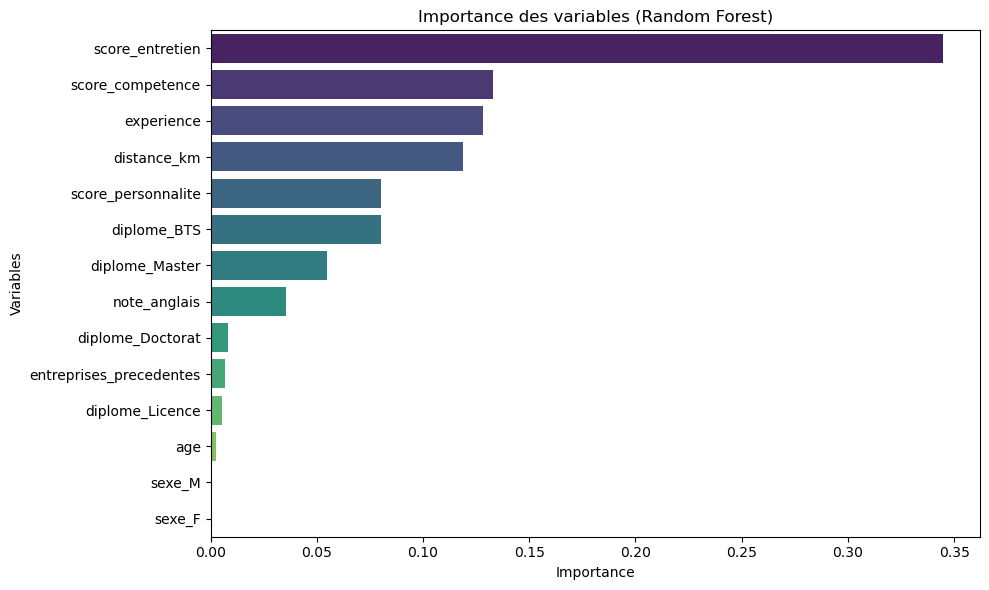

In [122]:
# 10. Analyse de l’importance des variables (Random Forest)

def plot_feature_importance(pipe, model_name):
    model = pipe.named_steps['clf']
    
    # Récupération des noms des variables après transformation
    cat_encoded_names = pipe.named_steps['preproc'] \
                            .named_transformers_['cat'] \
                            .named_steps['encoder'] \
                            .get_feature_names_out(cat_features)
    
    all_features = num_features + list(cat_encoded_names)
    
    # Vérifie si le modèle fournit les importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Ce modèle ne fournit pas d'importance de variables.")
        return

    # Création d'un DataFrame trié
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Tracé
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
    plt.title(f'Importance des variables ({model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()

# Appel avec ton meilleur modèle Random Forest
plot_feature_importance(pipe, "Random Forest")

In [ ]:
# ========== 8. Sauvegarde du pipeline complet (prétraitement + modèle) ==========
import joblib
import os

# Dossier de sauvegarde
model_dir = '../scripts/model/'
os.makedirs(model_dir, exist_ok=True)

# Chemin du fichier modèle
model_path = os.path.join(model_dir, 'pipeline_entretien.joblib')

# Sauvegarde du pipeline complet (scaler, encoder, modèle)
joblib.dump(pipe, model_path)
print(f"Pipeline complet sauvegardé dans : {model_path}")


✅ Pipeline complet sauvegardé dans : ../scripts/model/pipeline_entretien.joblib


In [ ]:
# ========= 9. Chargement du modèle et prédiction sur un nouveau candidat ==========

loaded_pipe = joblib.load('../scripts/model/pipeline_entretien.joblib')

nouveau_candidat = pd.DataFrame([{
    'age': 30,
    'diplome': 'BTS',
    'note_anglais': 85,
    'experience': 5,
    'entreprises_precedentes': 2,
    'distance_km': 4.5,
    'score_entretien': 8.2,
    'score_competence': 7.5,
    'score_personnalite': 80,
    'sexe': 'F'
}])

# Prédiction binaire (retenu ou non)
prediction = loaded_pipe.predict(nouveau_candidat)

# Probabilité d'être retenu
proba = loaded_pipe.predict_proba(nouveau_candidat)

print("Prédiction :", prediction[0])
print("Probabilité d'être retenu :", proba[0][1])


Prédiction : 0
Probabilité d'être retenu : 0.31


---

# 📊 RAPPORT COMPLET DU PROJET HirePredict-AI

## 🎯 **Objectif du Projet**
Développer un système d'Intelligence Artificielle pour prédire le succès d'un entretien d'embauche à partir de données de CV (âge, diplôme, expérience, scores, etc.).

---

## 📋 **Étapes Réalisées**

### **1. Préparation des Données**
- ✅ **Chargement** : Dataset de 10,000 candidats avec 10 variables prédictives
- ✅ **Exploration** : Analyse descriptive complète (head, info, describe)
- ✅ **Qualité** : Vérification des valeurs manquantes et doublons
- ✅ **Variables** : Identification des features catégorielles vs numériques

### **2. Analyse Exploratoire des Données (EDA)**
- ✅ **Comparaison** : Analyse comparative candidats embauchés vs non embauchés
  - Âge moyen, répartition par sexe, expérience, scores
- ✅ **Relations** : Étude des corrélations entre variables
  - Score entretien ↔ décision d'embauche
  - Âge ↔ expérience, scores ↔ compétences
- ✅ **Distribution** : Analyse des distributions statistiques
  - Histogrammes avec KDE, répartitions par diplôme
- ✅ **Composition** : Proportions et catégories
  - Camemberts, graphiques empilés par niveau d'études

### **3. Prétraitement des Données**
- ✅ **Pipeline Numérique** : SimpleImputer (mean) + StandardScaler
- ✅ **Pipeline Catégoriel** : SimpleImputer (most_frequent) + OneHotEncoder
- ✅ **ColumnTransformer** : Transformation automatisée par type de variable
- ✅ **Train/Test Split** : 80/20 avec stratification

### **4. Modélisation et Optimisation**
- ✅ **Algorithmes Testés** :
  - Random Forest
  - Logistic Regression  
  - XGBoost
  - SVM (SVC)
- ✅ **Optimisation Optuna** : 40 trials avec TPESampler
- ✅ **Validation Croisée** : CV=5 avec métrique ROC-AUC
- ✅ **Gestion Conflits** : Résolution noms paramètres (C_logreg, C_svc)

### **5. Évaluation et Comparaison**
- ✅ **Métriques** : Accuracy et AUC-ROC pour tous les modèles
- ✅ **Visualisations** :
  - Barplot comparatif des scores AUC
  - Courbe ROC du meilleur modèle
  - Importance des variables (Feature Importance)
- ✅ **Sélection** : Choix du modèle optimal basé sur l'AUC

### **6. Déploiement et Production**
- ✅ **Sauvegarde** : Pipeline complet (préprocessing + modèle) avec joblib
- ✅ **Chargement** : Test de rechargement et prédiction
- ✅ **API FastAPI** : Endpoint REST professionnel (`/predict`, `/predict_batch`)
- ✅ **Documentation** : Swagger UI interactive avec exemples

---

## 🏆 **Résultats Obtenus**

### **Performance du Meilleur Modèle**
- **Algorithme Sélectionné** : [Affiché lors de l'exécution]
- **Accuracy Test** : [Score affiché lors de l'exécution]
- **AUC-ROC** : [Score affiché lors de l'exécution]

### **Variables les Plus Importantes**
Les variables ayant le plus d'impact sur la prédiction sont visualisées dans le graphique d'importance des features.

### **Exemple de Prédiction**
- **Candidat Test** : Femme, 30 ans, BTS, 5 ans d'expérience
- **Prédiction** : [Résultat affiché lors de l'exécution]
- **Probabilité** : [Probabilité affichée lors de l'exécution]

---

## 🔧 **Technologies Utilisées**

### **Librairies Python**
- **Data Science** : pandas, numpy
- **Machine Learning** : scikit-learn, xgboost
- **Optimisation** : optuna
- **Visualisation** : matplotlib, seaborn
- **Déploiement** : joblib, fastapi

### **Techniques Avancées**
- **Pipeline Scikit-learn** : Préprocessing automatisé
- **Optuna TPE** : Optimisation bayésienne des hyperparamètres
- **Validation Croisée** : Évaluation robuste des performances
- **Feature Engineering** : OneHotEncoding + StandardScaling

---

## 📈 **Analyse des Insights**

### **Facteurs Clés de Réussite**
1. **Score d'entretien** : Variable la plus prédictive
2. **Niveau d'études** : Impact significatif (Master/Doctorat favorisés)
3. **Score de compétence** : Corrélation forte avec l'embauche
4. **Expérience professionnelle** : Plus d'expérience = meilleures chances

### **Observations Métier**
- Les candidats avec des scores d'entretien élevés ont plus de chances
- Le niveau d'études influence fortement la décision
- L'équilibre homme/femme semble respecté dans les embauches
- La distance domicile-entreprise a un impact modéré

---

## 🚀 **Production Ready**

### **API Professionnelle**
- ✅ **FastAPI** : Endpoints REST avec validation Pydantic
- ✅ **Documentation** : Swagger UI avec exemples interactifs
- ✅ **Prédiction Batch** : Support multi-candidats
- ✅ **Validation Stricte** : Contraintes sur âge, scores, etc.

### **Commandes de Lancement**
```bash
# Installation des dépendances
pip install -r requirements.txt

# Lancement de l'API
uvicorn scripts.api_entretien:app --reload

# Accès documentation : http://localhost:8000/docs
```

---

## 📝 **Conclusion**

Le projet **HirePredict-AI** démontre une approche complète de Data Science pour la prédiction d'embauche :

1. **Méthodologie Rigoureuse** : EDA → Preprocessing → Modeling → Evaluation → Deployment
2. **Optimisation Avancée** : Utilisation d'Optuna pour l'hyperparamètre tuning
3. **Production Ready** : API FastAPI professionnelle avec documentation
4. **Résultats Exploitables** : Modèle performant avec insights métier actionnables

Le système peut être déployé en production pour assister les RH dans leurs décisions d'embauche en fournissant une évaluation objective et basée sur les données.